1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.
- 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.

2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.	
- 모델 학습이 진행되면서 train loss와 validation loss가 감소하는 경향을 그래프를 통해 확인했으며, 실제 요약문에 있는 핵심 단어들이 요약 문장 안에 포함되었다.

3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.	
- 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교하고 분석 결과를 표로 정리하여 제시하였다.

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Step 1. 데이터 수집하기

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [3]:
data.sample(10)

,headlines,text
77299,Kapil Sharma wishes Sunil Grover on his 40th b...,Comedian Kapil Sharma took to Twitter to wish ...
72695,Bird Group interested to buy Air India's groun...,Indian aviation services firm Bird Group has w...
23482,1st black captain of Windies made cameo in a R...,"Sir Frank Worrell, the first black captain of ..."
1418,Malaika trolled for 20-yr-old pic in 10-yr-cha...,Malaika Arora got trolled on Instagram after s...
58485,"I never carry money, I don't even have a credi...","India's richest person Mukesh Ambani, who has ..."
35379,"Man posed as a doctor at AIIMS Delhi, caught a...",A 19-year-old man has been arrested after he a...
80709,Surging heat may force flights to cut down wei...,Rising temperatures due to climate change may ...
15760,24-year-old OYO founder Ritesh youngest on Hur...,Hotel aggregator OYO Rooms' 24-year-old Founde...
79763,Airlines lift ban on MP who manhandled airline...,"Four airlines including IndiGo, Air India, Spi..."
71696,"SC asks Google, FB to give inputs on content c...","The Supreme Court on Tuesday asked Google, Fac..."


# Step 2. 데이터 전처리하기 (추상적 요약)
실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

## 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [4]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [5]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


## 텍스트 정규화와 불용어 제거

In [6]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [7]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 198
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "

### 불용어 제거 및 텍스트 전처리

In [8]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word)>1)
    # 불용어 미제거
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
        

In [9]:
clean_text = data['text'].map(lambda x: preprocess_sentence(x))

print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  0    saurav kant alumnus upgrad iiit pg program mac...
1    kunal shah credit card bill payment platform c...
2    new zealand defeated india wickets fourth odi ...
3    aegon life iterm insurance plan customers enjo...
4    speaking sexual harassment allegations rajkuma...
Name: text, dtype: object


In [10]:
clean_headlines = data['headlines'].map(lambda x: preprocess_sentence(x))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  0     upgrad learner switches career ml al salary hike
1     delhi techie wins free food swiggy one year cred
2    new zealand end rohit sharma led india match w...
3    aegon life iterm insurance plan helps customer...
4             known hirani yrs metoo claims true sonam
Name: headlines, dtype: object


In [11]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [12]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### Null 값 확인

In [13]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


## 훈련데이터와 테스트데이터 나누기

### 샘플의 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
제목의 최소 길이 : 1
제목의 최대 길이 : 13
제목의 평균 길이 : 7.136183407889386


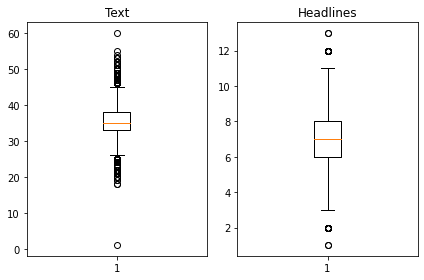

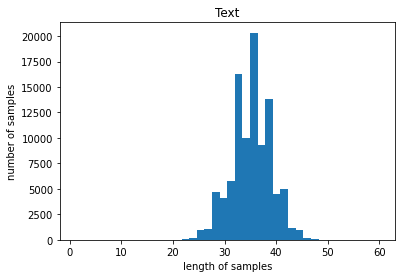

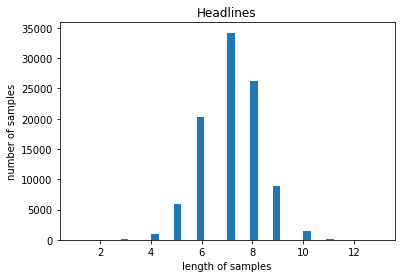

In [14]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('제목의 최소 길이 : {}'.format(np.min(headlines_len)))
print('제목의 최대 길이 : {}'.format(np.max(headlines_len)))
print('제목의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### 전체 샘플 중 길이가 %s 이하인 샘플의 비율 확인 -> 따로 처리 X

In [15]:
text_max_len = 40
headlines_max_len = 8

In [16]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [17]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.8925782838552258


In [18]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len) & 
            data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]

## 시작 토큰과 종료 토큰 추가하기

In [19]:
data['decoder_input'] = data['headlines'].apply(lambda x: 'sostoken ' + x)
data['decoder_target'] = data['headlines'].apply(lambda x: ' eostoken' + x)
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches career ml al salary hike,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches career ml al ...,eostokenupgrad learner switches career ml al ...
4,known hirani yrs metoo claims true sonam,speaking sexual harassment allegations rajkuma...,sostoken known hirani yrs metoo claims true sonam,eostokenknown hirani yrs metoo claims true sonam
6,india get lowest odi total new zealand,india recorded lowest odi total new zealand ge...,sostoken india get lowest odi total new zealand,eostokenindia get lowest odi total new zealand
7,govt directs alok verma join work day retirement,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma join work day...,eostokengovt directs alok verma join work day...
9,cong wins ramgarh bypoll rajasthan takes total...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll rajasthan ta...,eostokencong wins ramgarh bypoll rajasthan ta...


In [20]:
encoder_input = np.array(data['text']) #인코더 입력
decoder_input = np.array(data['decoder_input']) #디코더 입력
decoder_target = np.array(data['decoder_target']) #디코더 레이블

## 훈련 데이터, 테스트 데이터 분리

In [21]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[50431  4380 17587 ... 52436 74793 54870]


In [22]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [23]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 16382


In [24]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 65532
훈련 레이블의 개수 : 65532
테스트 데이터의 개수 : 16382
테스트 레이블의 개수 : 16382


## 단어 집합(vocabulary) 만들기 및 정수 인코딩

In [25]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [26]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 63137
등장 빈도가 6번 이하인 희귀 단어의 수: 43079
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20058
단어 집합에서 희귀 단어의 비율: 68.23098975244311
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.890294295370795


In [27]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [28]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[546, 5265, 72, 75, 130, 366, 154, 1649, 277, 730, 72, 722, 1144, 486, 5096, 5096, 1119, 24, 324, 89, 2319, 36, 6727, 1807, 352, 456, 1850, 2, 5096, 5096, 5, 2925, 1154, 6017, 3026], [528, 193, 1363, 4192, 38, 2447, 49, 717, 5934, 3312, 1018, 1, 205, 308, 6448, 3082, 687, 721, 1063, 721, 23, 242, 438, 24, 28, 5, 2871, 2447, 2], [2246, 593, 23, 222, 950, 5514, 1785, 17, 274, 1003, 2085, 369, 897, 2246, 2169, 17, 2659, 1505, 3757, 355, 124, 2009, 92, 3446, 1355, 124, 82, 23, 1483, 81, 2065, 1505, 3757]]


In [29]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [30]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 27555
등장 빈도가 5번 이하인 희귀 단어의 수: 18268
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9287
단어 집합에서 희귀 단어의 비율: 66.29649791326439
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.821332929991021


In [31]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 55, 24], [1, 1458, 95, 42, 30], [1, 907, 1533, 10, 64, 1128, 758], [1, 819, 715, 281, 231, 171], [1, 1320, 116, 621, 19]]
target
decoder  [[55, 24], [95, 42, 30], [1533, 10, 64, 1128, 758], [819, 715, 281, 231, 171], [116, 621, 19]]


In [32]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 259
삭제할 테스트 데이터의 개수 : 59
훈련 데이터의 개수 : 65273
훈련 레이블의 개수 : 65273
테스트 데이터의 개수 : 16323
테스트 레이블의 개수 : 16323


## 패딩하기

In [33]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

# Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

## 인코더 설계

In [34]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(enc_emb)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(enc_emb)

## 디코더 설계

In [35]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 128)    256000      input_2[0][0]                    
______________________________________________________________________________________________

## 어텐션 메커니즘

In [36]:
from tensorflow.keras.layers import AdditiveAttention

attn_layer = AdditiveAttention(name='attention_layer')
attn_out = attn_layer([decoder_outputs, encoder_outputs])

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 128)    256000      input_2[0][0]                    
____________________________________________________________________________________________

In [37]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
255/255 [==============================] - 13s 31ms/step - loss: 3.9695 - val_loss: 3.7989
Epoch 2/50
255/255 [==============================] - 7s 29ms/step - loss: 3.6726 - val_loss: 3.4872
Epoch 3/50
255/255 [==============================] - 7s 29ms/step - loss: 3.4076 - val_loss: 3.2915
Epoch 4/50
255/255 [==============================] - 7s 29ms/step - loss: 3.2067 - val_loss: 3.1299
Epoch 5/50
255/255 [==============================] - 7s 29ms/step - loss: 3.0522 - val_loss: 3.0288
Epoch 6/50
255/255 [==============================] - 7s 29ms/step - loss: 2.9278 - val_loss: 2.9418
Epoch 7/50
255/255 [==============================] - 7s 29ms/step - loss: 2.8182 - val_loss: 2.8756
Epoch 8/50
255/255 [==============================] - 7s 29ms/step - loss: 2.7255 - val_loss: 2.8213
Epoch 9/50
255/255 [==============================] - 7s 29ms/step - loss: 2.6424 - val_loss: 2.7816
Epoch 10/50
255/255 [==============================] - 7s 29ms/step - loss: 2.5657 - val_l

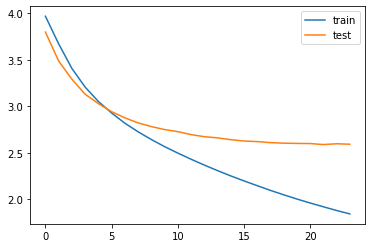

In [38]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 인퍼런스 모델 구현하기

In [53]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음
tar_index_to_word[0] = ''  # padding 대응용

In [40]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [41]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [59]:
import time # 시간 측정을 위해 추가

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    print("Encoder prediction done.") # 인코더 예측 완료 시점 확인

    # <SOS> 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index.get('sostoken', -1)

    stop_condition = False
    decoded_sentence = ''
    step = 0 # 스텝 카운터
    
    while not stop_condition: 
        step += 1
#         print(f"  [Step {step}] Decoding started...") # 각 스텝 시작 알림

        start_time = time.time() # predict 시작 시간 기록
        # 이전 상태를 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        predict_time = time.time() - start_time # predict 소요 시간 계산
#         print(f"  [Step {step}] Decoder prediction done (took {predict_time:.4f}s).") # 예측 완료 및 시간 출력

        # 가장 확률 높은 토큰 인덱스 찾기
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        # 인덱스를 단어로 변환 (.get 사용 권장, 없으면 'UNK' 등으로 표시)
        sampled_token = tar_index_to_word.get(sampled_token_index, f'UNK_IDX_{sampled_token_index}') 
#         print(f"  [Step {step}] Predicted token: '{sampled_token}' (Index: {sampled_token_index})")

        if (sampled_token!='eostoken' and not sampled_token.startswith('UNK_IDX')): # UNK 토큰은 문장에 추가하지 않음 (선택적)
            decoded_sentence += ' '+sampled_token
#         print(f"  [Step {step}] Current sentence: '{decoded_sentence.strip()}'")

        # 종료 조건 확인
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
#             print(f"  [Step {step}] Stop condition met (token: {sampled_token}, length: {len(decoded_sentence.split())})")
            stop_condition = True

        # 다음 입력 설정
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태 업데이트
        e_h, e_c = h, c
        
        # (선택적) 무한 루프 방지용 최대 스텝 제한
        if step >= headlines_max_len + 2: # 최대 길이보다 조금 더 여유롭게 설정
#              print(f"  [Step {step}] Reached max steps, forcing stop.")
             stop_condition = True

    return decoded_sentence.strip()

# Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

## 모델 테스트하기

In [60]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp = ''
    
    sostoken_index = tar_word_to_index.get('sostoken', -1) 
    eostoken_index = tar_word_to_index.get('eostoken', -1)
    
    for i in input_seq:
        # 0 (패딩), 'sostoken' 인덱스, 'eostoken' 인덱스를 제외
        if i != 0 and i != sostoken_index and i != eostoken_index:
             # .get() 메소드를 사용하여 사전에 없는 인덱스일 경우 빈 문자열 반환 (오류 방지)
            word = tar_index_to_word.get(i, '') 
            if word: # 빈 문자열이 아닐 경우에만 공백과 함께 추가
                temp = temp + word + ' '
    return temp.strip() # 문자열 앞뒤 공백 제거

In [62]:
for i in range(50, 60):
    print(f"Processing sample {i}...") # 진행 상황 출력
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

Processing sample 50...
원문 : four people reported dead major fire broke lucknow international hotel tuesday around people staying hotel fire started however evacuated safety police said strict action taken hotel investigation part police added 
실제 요약 : dead fire breaks lucknow hotel
Encoder prediction done.
예측 요약 : fire hotel fire


Processing sample 51...
원문 : bjp led nda government defeated confidence motion lok sabha bjp leader rao saturday said trailer people country seen floor parliament happen congress party move yet another confidence vote pm added 
실제 요약 : trailer bjp motion vote
Encoder prediction done.
예측 요약 : eostokenbjp bjp


Processing sample 52...
원문 : talking first ever tour england brian lara said threw keys car gifted towards sat passenger seat knew roads england lara revealed delivering spirit cricket lord cricket ground london 
실제 요약 : recalls time driver
Encoder prediction done.
예측 요약 : first run


Processing sample 53...
원문 : two women reported drowned punjab canal

# Step 5. Summa을 이용해서 추출적 요약해보기, Extractive 요약, Abstractive 요약 결과 비교

In [93]:
import requests
from summa.summarizer import summarize

try:
    original_data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
    
    original_data.dropna(subset=['text'], inplace=True)
    original_data.drop_duplicates(subset=['text'], inplace=True)
    original_data.reset_index(drop=True, inplace=True) # 인덱스 재설정
except FileNotFoundError:
    print("Error: 'news_summary_more.csv' 파일을 찾을 수 없습니다.")
    original_data = None

# 요약을 수행할 샘플 선택 (예: 50번째 기사)
# 이 인덱스는 위에서 로드/정리한 original_data 기준입니다.
sample_index = 50

if original_data is not None and sample_index < len(original_data):
    # 선택한 샘플의 원본 'text' 가져오기
    original_text_to_summarize = original_data['text'].iloc[sample_index]

    print("--- 추출적 요약 (Summa) ---")
    print("\n[원본 텍스트]")
    print(original_text_to_summarize)

    # summarize 함수 사용 (ratio 또는 words 파라미터 사용)
    # ratio: 원본 텍스트 대비 요약문의 비율 (예: 0.2 = 20%)
    # words: 요약문의 최대 단어 수 지정 (결과는 근사치일 수 있음)
    print("\n[추출적 요약 결과 (약 25단어)]")
    summary_result_words = summarize(original_text_to_summarize, words=25)
    print(summary_result_words)
    
    preprocessed_text = preprocess_sentence(original_text_to_summarize)
    sequence = tar_tokenizer.texts_to_sequences([preprocessed_text])
    padded_seq = pad_sequences(sequence, maxlen=text_max_len, padding='post')

    # 추상적 요약 (모델 디코딩)
    print("\n추상적 요약:")

    print(decode_sequence(padded_seq))


--- 추출적 요약 (Summa) ---

[원본 텍스트]
Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL). All agencies including regulators of the government have failed to track nefarious deals, he said. This comes after a media report on Tuesday accused DHFL's controlling shareholders of diverting funds to shell companies to buy assets.

[추출적 요약 결과 (약 25단어)]
Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL).

추상적 요약:
Encoder prediction done.
central central


## 📊 분석 결과표

| 항목 | 추출적 요약 | 추상적 요약 |
|------|--------------|--------------|
| **요약 방식** | 원문에서 핵심 문장을 발췌 | 원문 내용을 재구성해 새 문장 생성 |
| **정확성** | 높음 | 매우 낮음 |
| **자연스러움** | 자연스러움 | 부자연스럽고 의미 없음 |
| **정보 보존** | 주요 정보 대부분 포함 | 정보 손실 심각 |
| **개선 필요성** | 낮음 | 높음 (모델 재학습 필요) |
